In [2]:
import numpy as np
from scipy import ndimage
import matplotlib
from matplotlib import pyplot as plt
from PIL import Image
import glob,os
import dlib
import cv2
from scipy import ndimage
from sklearn.decomposition import PCA
from skimage import feature

In [3]:
#set seed parametr for random selecting operations
seed=10

In [4]:
def preprocesing_images(path_="dataset/s*/*.pgm"):
    #find out the number of photos
    files=glob.glob(path_)
    rows=len(files)
    print(f"Number of photos: {rows}")
    
    #find out photo size
    fname=files[11]
    img=np.array(Image.open(fname))
    columns=img.shape[0]*img.shape[1]
    print(f'photo size: {img.shape}')
    print('Image sample:')
    plt.imshow(img, cmap='gray')
    
    return files,rows,columns

Number of photos: 400
photo size: (112, 92)
Image sample:


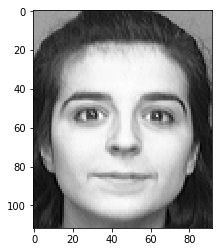

In [5]:
#getting file names of all images for dataset
files, rows, columns = preprocesing_images(path_="dataset/s*/*.pgm")

In [6]:
def create_data_matrix(files,rows,columns):
    row=0
    labels=[]
    data=np.zeros((rows,columns))
    for f in files:
        im=np.array(Image.open(f))
        im=im.reshape(1,im.shape[0]*im.shape[1])
   
        #create dataset: "data"
        data[row,:]=im
        row+=1
   
        #create labels for images: "labels"
        fname,ext = os.path.splitext(f)
        _,name,index, = fname.split('\\')
        labels.append(int(name[1:]))
    labels=np.array(labels).reshape(len(labels),1)
    return data, labels

In [7]:
#creating dataset from images: data and labels
data, labels = create_data_matrix(files,rows,columns)
print(f'Dataset shape: {data.shape}')
print(f'Labels shape: {labels.shape}')

Dataset shape: (400, 10304)
Labels shape: (400, 1)


In [8]:
def vec_to_image(v,w=(92,112)):
    img=v.reshape(w[1],w[0])
    return img

def show_image(ind,data,labels,size=(92,112)):
    img=vec_to_image(data[ind],size)
    plt.imshow(img, cmap='gray')
    plt.title(f'label: {np.squeeze(labels)[ind]}')
    
#rotation angle in degree
def image_rotation(path_image,angle=4,flag=1):
    image_to_rotate=cv2.imread(path_image,cv2.COLOR_BGR2GRAY)
    rotated = ndimage.rotate(image_to_rotate, angle*flag)
    #plt.imshow(rotated,cmap='gray')
    return rotated

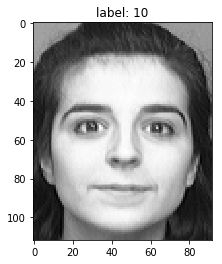

In [9]:
#test, select and show photo with index=11
index=11
show_image(index,data,labels)

In [10]:
def split_dataset(data,seed=seed,n=80):
    np.random.seed(seed=seed)
    
    #create indexes for test dataset, random choise
    samples=range(data.shape[0])
    random_index=np.random.choice(samples,n,replace=False)
    
    #create test dataset
    test_set=data[random_index,:]
    test_labels=labels[random_index]
    
    #create train data_set
    train_set=np.delete(data,random_index,axis=0)
    train_labels=np.delete(labels,random_index)
    train_labels=train_labels.reshape(len(train_labels),1)
    
    return train_set, train_labels, test_set, test_labels 

In [11]:
# split data to train and test
train_set, train_labels, test_set, test_labels = split_dataset(data,seed=seed,n=80)
print(f'Train set shape: {train_set.shape}, train labels shape: {train_labels.shape}')
print(f'Test set shape: {test_set.shape}, test labels shape: {test_labels.shape}')
train_orginal=train_set
test_original=test_set

Train set shape: (320, 10304), train labels shape: (320, 1)
Test set shape: (80, 10304), test labels shape: (80, 1)


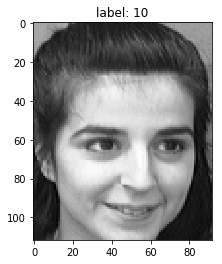

In [12]:
show_image(10,train_set,train_labels)

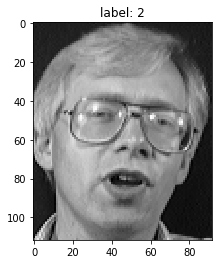

In [13]:
show_image(10,test_set,test_labels)

In [14]:
# load unknown photos and identify employee
def identify_employee(train_set,unknown_set,seed=seed,kind='euclid'):
    np.random.seed(seed=seed)
    min_dist=[]
    if kind=='euclid':
        for ind in range(unknown_set.shape[0]):
            dist=np.linalg.norm(train_set-unknown_set[ind,:],axis=1,keepdims=True)
            min_dist.append(np.argmin(dist))
        result=np.array(min_dist).reshape(len(min_dist),1)
    if kind=='cosine':
        for ind in range(unknown_set.shape[0]):
            dist=cosine_distance(train_set,unknown_set[ind,:])
            min_dist.append(np.argmin(dist))
        result=np.array(min_dist).reshape(len(min_dist),1)
    return result

def accuracy(train_labels,test_labels, predict_index, index=1):
    if index:
        yhat=np.squeeze(train_labels[predict_index])
    else:
        yhat=predict_index
    ytest=np.squeeze(test_labels)
    compare=yhat==ytest
    err_index=np.where(compare==False)
    true_index=np.where(compare==True)
    true_answ=sum(compare)
    acc = (true_answ/test_labels.shape[0])*100     
    #return acc,np.squeeze(err_index),np.squeeze(true_index)
    return acc,err_index,true_index

def cosine_distance(X,v):
    A=np.sum(X*v,axis=1,keepdims=True)
    Z=np.linalg.norm(X,axis=1,ord=2,keepdims=True)*np.linalg.norm(v)
    return 1-A/Z

def show_errors(train_set,train_labels,test_set,test_labels,predict_index,err_index,figsize=(10,10),index=1,size=(92,112),X=train_orginal,X_test=test_original):
    n=1
    if len(err_index[0])<=1:
        l=1
        print('Predict photo                          Real photo')
        plt.figure(figsize=figsize)
        plt.subplot(l,2,n)
        if index==True:
            show_image(predict_index[err_index],train_set,train_labels,size=size)
        else:
            show_image(np.where(train_labels==predict_index[err_index])[0][0],train_set,train_labels,size=size)
        n+=1
        plt.subplot(l,2,n)
        show_image(err_index,test_set,test_labels)  
    else:
        err_index=np.squeeze(err_index)
        l=err_index.shape[0]
        print('Predict photo                          Real photo')
        plt.figure(figsize=figsize)
        for i in err_index:
            plt.subplot(l,2,n)
            if index==1:
                show_image(predict_index[i],train_set,train_labels,size=size)
            elif index==2:
                show_image(np.where(train_labels==predict_index[i])[0][0],train_set,train_labels,size=size)
            elif index==3:
                show_image(predict_index[i],X,train_labels,size=size)
                           
            n+=1
            plt.subplot(l,2,n)
            if index==3:
                show_image(i,X_test,test_labels,size=size)
            else:
                show_image(i,test_set,test_labels,size=size)
            n+=1

In [15]:
def model_face_recognition(train_set,train_labels,test_set,test_labels,seed=seed,kind='euclid',
                           show_err=True,show_correct=False,size=(92,112),figsize=(10,10), index=1, norm=0, 
                           pca_flag=False, pca_energy=0.98, lbp_flag=False):
    
    """
    This function recognise face.
    
    Argument:
    train_set -- train dataset
    train_labels -- labels for train dataset
    test_set -- test dataset
    test_labels - labels for test dataset
    seed -- seed for random operations (default value 10)
    kind -- type of algorithm for computing distance between vectors, defaul algorithm euclid distance 'euclid'
    show_err -- flag for showing recognation errors, default value = True
    show_correct -- flag for showing samples of corect recognition, default value = False
    size -- size of image, width - height, default value = (92,112)
    figsize -- figsize for displaying errors ot true answers
    index -- type of image processing for method show_erros, default value=1
    norm -- type of normalization. 1 - substract mean, 2 - standardize data, 0 - without normalization
    pca_flag -- turn on PCA
    pca_energy -- coefficient of explained bariance, default value=0.98
    
    Returns:
    acc -- Accuracy
    """
    #Normalization
    if norm==1:
        train_set=subtruct_mean(train_set)
        test_set=subtruct_mean(test_set)
    elif norm==2:
        train_set=standard_norm(train_set)
        test_set=standard_norm(test_set)
        
        
    if pca_flag:
        train_set, test_set, n_components=pca_model(train_set, test_set, pca_energy=pca_energy, kind_normalize=norm)
        
    predict_index=identify_employee(train_set,test_set,seed=seed,kind=kind)
    
    acc,err_index,true_index=accuracy(train_labels,test_labels, predict_index,index=index)
    print(f'Accuracy for test dataset = {acc}')
    #Error visualization
    if show_err:
        show_errors(train_set,train_labels,test_set,test_labels,predict_index,err_index,index=index,figsize=figsize,size=size)
    if show_correct:
        show_errors(train_set,train_labels,test_set,test_labels,predict_index,true_index,index=index,figsize=(10,90),size=size)
    return acc

Accuracy for test dataset = 95.0
Predict photo                          Real photo


95.0

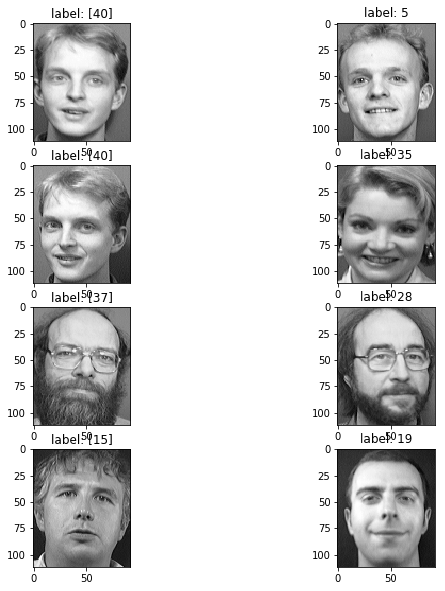

In [16]:
# Result without normalization
model_face_recognition(train_set,train_labels,test_set,test_labels,seed=seed,kind='euclid',show_err=True)

Accuracy for test dataset = 95.0
Predict photo                          Real photo


95.0

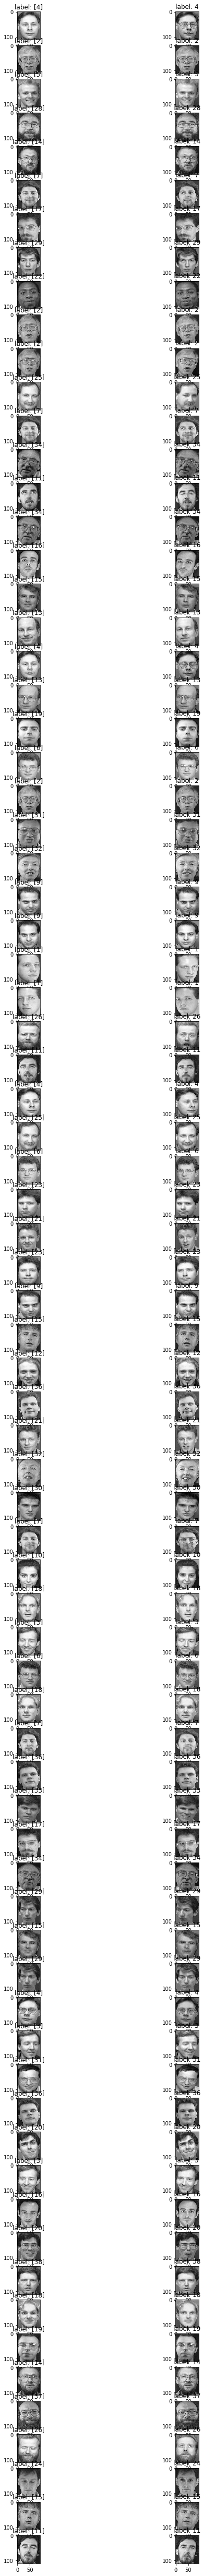

In [17]:
#demonstration how model can identify emploee
model_face_recognition(train_set,train_labels,test_set,test_labels,seed=seed,kind='euclid',show_err=False,show_correct=True)

In [18]:
# make shuffle for train dataset and define accuracy
np.random.seed(seed=seed)
index_shuffle=np.arange(train_set.shape[0])
np.random.shuffle(index_shuffle)
model_face_recognition(train_set,train_labels,train_set[index_shuffle],train_labels[index_shuffle],seed=seed,kind='euclid',show_err=False)

Accuracy for test dataset = 100.0


100.0

## Optimization / Normalization steps

In [19]:
#subtruct mean value from the feature
def subtruct_mean(x):
    return x-x.mean(axis=0,keepdims=True)

# standard score: (X-mu)/sigma
def standard_norm(X):
    A=(X-X.mean(axis=1, keepdims=True))/X.std(axis=1, keepdims=True)
    return A

Accuracy for test dataset = 95.0
Predict photo                          Real photo


95.0

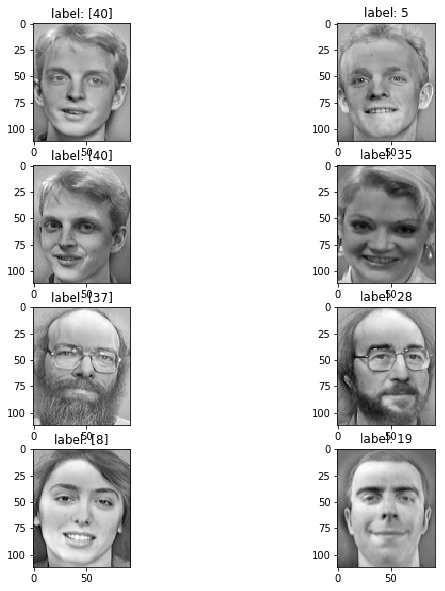

In [20]:
# Accuracy for normalized dataset, method - subtruct_mean 
model_face_recognition(train_set,train_labels,test_set,test_labels,seed=seed,kind='euclid',show_err=True,norm=1)

In [21]:
#Accuracy didn't change, after normalization through subtraction mean from each feature

Accuracy for test dataset = 92.5
Predict photo                          Real photo


92.5

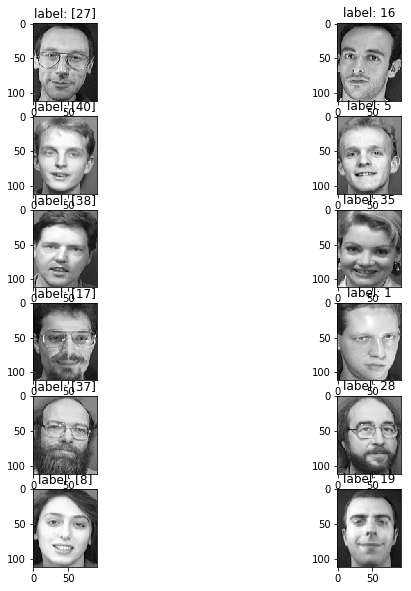

In [22]:
# Accuracy for normalized dataset, method - standard score: (X-mu)/sigma
model_face_recognition(train_set,train_labels,test_set,test_labels,seed=seed,kind='euclid',show_err=True,norm=2)

In [23]:
# Accuracy become worse after applying standardization of dataset

## Face alighment

In [24]:
#Rotation

In [25]:
#I choose images that have a bit deviated from horizontal position
#need to right rotate
rigt_rotate=['dataset\\s2\\1.pgm','dataset\\s5\\10.pgm','dataset\\s9\\5.pgm',
'dataset\\s9\\10.pgm','dataset\\s11\\2.pgm','dataset\\s12\\6.pgm',
'dataset\\s13\\3.pgm','dataset\\s13\\4.pgm','dataset\\s16\\8.pgm','dataset\\s17\\7.pgm',
'dataset\\s20\\4.pgm','dataset\\s20\\6.pgm', 'dataset\\s25\\3.pgm',
'dataset\\s26\\2.pgm','dataset\\s30\\9.pgm','dataset\\s31\\1.pgm',
'dataset\\s33\\1.pgm','dataset\\s33\\6.pgm','dataset\\s34\\7.pgm',
'dataset\\s34\\7.pgm','dataset\\s35\\2.pgm','dataset\\s35\\4.pgm',
'dataset\\s36\\4.pgm','dataset\\s36\\5.pgm','dataset\\s37\\3.pgm',
'dataset\\s38\\1.pgm','dataset\\s38\\6.pgm','dataset\\s40\\1.pgm',
'dataset\\s40\\3.pgm','dataset\\s40\\9.pgm']
#need to left rotate
left_rotate=['dataset\\s2\\6.pgm','dataset\\s2\\9.pgm','dataset\\s3\\4.pgm','dataset\\s3\\6.pgm',
'dataset\\s4\\1.pgm', 'dataset\\s4\\3.pgm', 'dataset\\s4\\8.pgm','dataset\\s9\\7.pgm',
'dataset\\s11\\8.pgm','dataset\\s13\\2.pgm','dataset\\s15\\1.pgm',
'dataset\\s15\\4.pgm','dataset\\s25\\9.pgm','dataset\\s28\\10.pgm',
'dataset\\s30\\3.pgm','dataset\\s31\\7.pgm','dataset\\s33\\2.pgm',
'dataset\\s33\\8.pgm','dataset\\s37\\7.pgm']

In [26]:
def crop_after_rotation(img):
    h=112
    w=92
    new_h=img.shape[0]
    new_w=img.shape[1]
    delta_h=int((new_h-h)/2)
    delta_w=np.int((new_w-w)/2)
    crop_img=img[delta_h:img.shape[0]-delta_h, delta_w:img.shape[1]-delta_w]
    if crop_img.shape != (112, 92):
        print ('err')
        crop_img=cv2.resize(crop_img,(112, 92))
    return crop_img

In [27]:
def create_data_matrix_2(files,rows,columns,rotation,angle):
    row=0
    labels=[]
    data=np.zeros((rows,columns))
    for f in files:
        if f in rotation[0]:
            print('right')
            im=image_rotation(f,angle=angle,flag=-1)
            im=crop_after_rotation(im)
        elif f in rotation[1]:
            print('left')
            im=image_rotation(f,angle=angle,flag=1)  
            im=crop_after_rotation(im)
        else:
            im=np.array(Image.open(f))
        print(f'{f} - {im.shape}')
        im=im.reshape(1,im.shape[0]*im.shape[1])
   
        #create dataset: "data"
        data[row,:]=im
        row+=1
   
        #create labels for images: "labels"
        fname,ext = os.path.splitext(f)
        _,name,index, = fname.split('\\')
        labels.append(int(name[1:]))
    labels=np.array(labels).reshape(len(labels),1)
    return data, labels

In [28]:
rotation=[rigt_rotate,left_rotate]
data_rotate, labels = create_data_matrix_2(files,rows,columns,rotation,angle=4)

dataset\s1\1.pgm - (112, 92)
dataset\s1\10.pgm - (112, 92)
dataset\s1\2.pgm - (112, 92)
dataset\s1\3.pgm - (112, 92)
dataset\s1\4.pgm - (112, 92)
dataset\s1\5.pgm - (112, 92)
dataset\s1\6.pgm - (112, 92)
dataset\s1\7.pgm - (112, 92)
dataset\s1\8.pgm - (112, 92)
dataset\s1\9.pgm - (112, 92)
dataset\s10\1.pgm - (112, 92)
dataset\s10\10.pgm - (112, 92)
dataset\s10\2.pgm - (112, 92)
dataset\s10\3.pgm - (112, 92)
dataset\s10\4.pgm - (112, 92)
dataset\s10\5.pgm - (112, 92)
dataset\s10\6.pgm - (112, 92)
dataset\s10\7.pgm - (112, 92)
dataset\s10\8.pgm - (112, 92)
dataset\s10\9.pgm - (112, 92)
dataset\s11\1.pgm - (112, 92)
dataset\s11\10.pgm - (112, 92)
right
dataset\s11\2.pgm - (112, 92)
dataset\s11\3.pgm - (112, 92)
dataset\s11\4.pgm - (112, 92)
dataset\s11\5.pgm - (112, 92)
dataset\s11\6.pgm - (112, 92)
dataset\s11\7.pgm - (112, 92)
left
dataset\s11\8.pgm - (112, 92)
dataset\s11\9.pgm - (112, 92)
dataset\s12\1.pgm - (112, 92)
dataset\s12\10.pgm - (112, 92)
dataset\s12\2.pgm - (112, 92)
datas

dataset\s37\5.pgm - (112, 92)
dataset\s37\6.pgm - (112, 92)
left
dataset\s37\7.pgm - (112, 92)
dataset\s37\8.pgm - (112, 92)
dataset\s37\9.pgm - (112, 92)
right
dataset\s38\1.pgm - (112, 92)
dataset\s38\10.pgm - (112, 92)
dataset\s38\2.pgm - (112, 92)
dataset\s38\3.pgm - (112, 92)
dataset\s38\4.pgm - (112, 92)
dataset\s38\5.pgm - (112, 92)
right
dataset\s38\6.pgm - (112, 92)
dataset\s38\7.pgm - (112, 92)
dataset\s38\8.pgm - (112, 92)
dataset\s38\9.pgm - (112, 92)
dataset\s39\1.pgm - (112, 92)
dataset\s39\10.pgm - (112, 92)
dataset\s39\2.pgm - (112, 92)
dataset\s39\3.pgm - (112, 92)
dataset\s39\4.pgm - (112, 92)
dataset\s39\5.pgm - (112, 92)
dataset\s39\6.pgm - (112, 92)
dataset\s39\7.pgm - (112, 92)
dataset\s39\8.pgm - (112, 92)
dataset\s39\9.pgm - (112, 92)
left
dataset\s4\1.pgm - (112, 92)
dataset\s4\10.pgm - (112, 92)
dataset\s4\2.pgm - (112, 92)
left
dataset\s4\3.pgm - (112, 92)
dataset\s4\4.pgm - (112, 92)
dataset\s4\5.pgm - (112, 92)
dataset\s4\6.pgm - (112, 92)
dataset\s4\7.pgm 

In [29]:
data_rotate.shape

(400, 10304)

In [30]:
# split data to train and test
train_set_rot, train_labels, test_set_rot, test_labels = split_dataset(data_rotate,seed=seed,n=80)
print(f'Train set shape: {train_set_rot.shape}, train labels shape: {train_labels.shape}')
print(f'Test set shape: {test_set_rot.shape}, test labels shape: {test_labels.shape}')

Train set shape: (320, 10304), train labels shape: (320, 1)
Test set shape: (80, 10304), test labels shape: (80, 1)


Accuracy for test dataset = 95.0
Predict photo                          Real photo


95.0

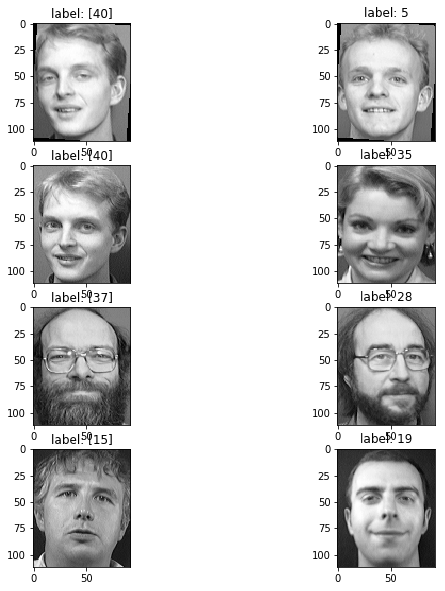

In [31]:
# Result without normalization
model_face_recognition(train_set_rot,train_labels,test_set_rot,test_labels,seed=seed,kind='euclid',show_err=True)

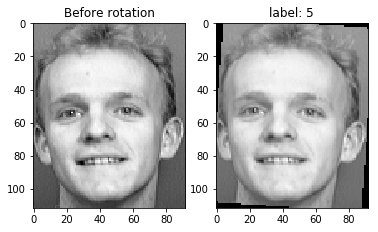

In [32]:
plt.subplot(121)
show_image(22,test_set,test_labels)
plt.title('Before rotation')
plt.subplot(122)
plt.title('After rotation')
show_image(22,test_set_rot,test_labels)

Accuracy for test dataset = 95.0
Predict photo                          Real photo


95.0

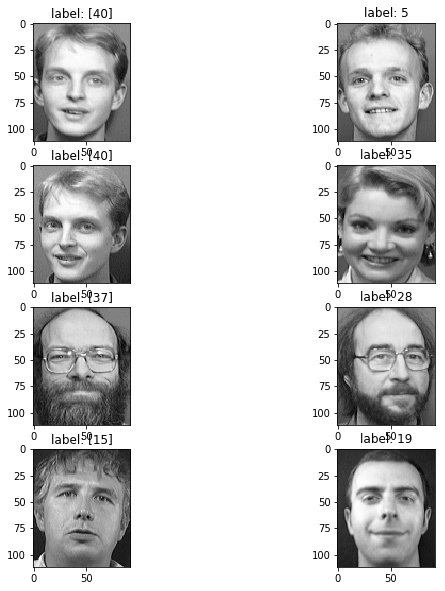

In [33]:
#Let's comoare results and give model test dataset without rotation
model_face_recognition(train_set_rot,train_labels,test_set,test_labels,seed=seed,kind='euclid',show_err=True)

In [34]:
#face rotation don't improve accuracy

In [35]:
#face alignment - 5 face landmarks

In [36]:
# I use dlib and 5 face landmarks for face alighment
def aligment_image_2(img_path,size=112):
    predictor_path = "shape_predictor_5_face_landmarks.dat"
    face_file_path = img_path
    img =  cv2.imread(face_file_path)
    # Load all the models we need: a detector to find the faces, a shape predictor
    # to find face landmarks so we can precisely localize the face
    detector = dlib.get_frontal_face_detector()
    sp = dlib.shape_predictor(predictor_path)

    # Ask the detector to find the bounding boxes of  face.
    dets = detector(img)
    num_faces = len(dets)
    if num_faces == 0:
        print("Sorry, there were no faces found in '{}'".format(face_file_path))
        #image=cv2.resize(img,(size,size))
        image=img
    else:
        # Find the 5 face landmarks we need to do the alignment.
        faces = dlib.full_object_detections()
        for detection in dets:
            faces.append(sp(img, detection))
        # Get the aligned face image
        image = dlib.get_face_chip(img, faces[0],size=size)
        #plt.imshow(image)
    im=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    im=crop_after_rotation(im)
    im=im.reshape(1,im.shape[0]*im.shape[1])
    return im

In [37]:
def aligned_dataset_2(files,size=120):
    rows=len(files)
    data_aligned=np.zeros((rows,112*92))
    row=0
    for f in files:
        img_vec=aligment_image_2(f,size=size)
        print(f)
        data_aligned[row,:]=img_vec
        row+=1
    print (f'Face aligned for dataset complete, new shape {data_aligned.shape}')
    return data_aligned

In [38]:
#execution time = 5 minutes
data_aligned_2= aligned_dataset_2(files)

dataset\s1\1.pgm
dataset\s1\10.pgm
dataset\s1\2.pgm
dataset\s1\3.pgm
dataset\s1\4.pgm
dataset\s1\5.pgm
dataset\s1\6.pgm
dataset\s1\7.pgm
dataset\s1\8.pgm
dataset\s1\9.pgm
dataset\s10\1.pgm
dataset\s10\10.pgm
dataset\s10\2.pgm
dataset\s10\3.pgm
dataset\s10\4.pgm
dataset\s10\5.pgm
dataset\s10\6.pgm
dataset\s10\7.pgm
dataset\s10\8.pgm
dataset\s10\9.pgm
dataset\s11\1.pgm
dataset\s11\10.pgm
dataset\s11\2.pgm
dataset\s11\3.pgm
dataset\s11\4.pgm
dataset\s11\5.pgm
dataset\s11\6.pgm
dataset\s11\7.pgm
dataset\s11\8.pgm
dataset\s11\9.pgm
dataset\s12\1.pgm
dataset\s12\10.pgm
dataset\s12\2.pgm
dataset\s12\3.pgm
dataset\s12\4.pgm
dataset\s12\5.pgm
dataset\s12\6.pgm
dataset\s12\7.pgm
dataset\s12\8.pgm
dataset\s12\9.pgm
dataset\s13\1.pgm
dataset\s13\10.pgm
dataset\s13\2.pgm
dataset\s13\3.pgm
dataset\s13\4.pgm
dataset\s13\5.pgm
dataset\s13\6.pgm
dataset\s13\7.pgm
dataset\s13\8.pgm
dataset\s13\9.pgm
dataset\s14\1.pgm
dataset\s14\10.pgm
dataset\s14\2.pgm
dataset\s14\3.pgm
dataset\s14\4.pgm
dataset\s14\5.

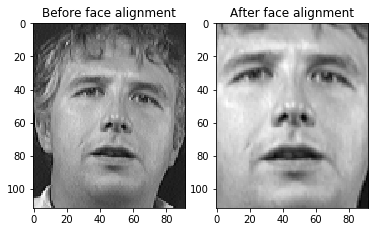

In [39]:
plt.subplot(121)
plt.title('Before face alignment')
plt.imshow(vec_to_image(data[60]),cmap='gray')
plt.subplot(122)
plt.title('After face alignment')
plt.imshow(vec_to_image(data_aligned_2[60]),cmap='gray')

In [40]:
# split data to train and test
train_set_aligned_crop, train_labels_aligned, test_set_aligned_crop, test_labels_aligned = split_dataset(data_aligned_2,seed=seed,n=80)
print(f'Train set shape: {train_set_aligned_crop.shape}, train labels shape: {train_labels_aligned.shape}')
print(f'Test set shape: {test_set_aligned_crop.shape}, test labels shape: {test_labels_aligned.shape}')

Train set shape: (320, 10304), train labels shape: (320, 1)
Test set shape: (80, 10304), test labels shape: (80, 1)


Accuracy for test dataset = 88.75
Predict photo                          Real photo


88.75

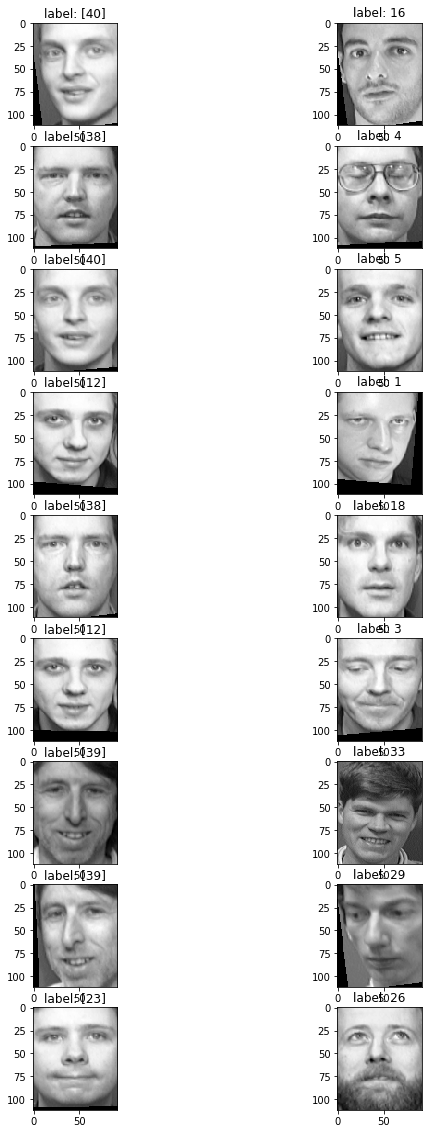

In [41]:
model_face_recognition(train_set_aligned_crop, train_labels_aligned, test_set_aligned_crop, test_labels_aligned,seed=seed,kind='euclid',show_err=True,figsize=(10,20))

In [42]:
#Face alignment applying add noise to dataset. Accuracy became worse then before

## PCA

In [43]:
pca_energy_list=list([0.95, 0.98, 0.99, 1.00])
pca_energy=0.98

In [44]:
# kind_normalize='subtruct_mean' or standard_norm
def pca_model(train_set, test_set, pca_energy=0.98, kind_normalize=1):
    if kind_normalize==1:
        #data normalization
        train_set_norm=subtruct_mean(train_set)
        test_set_norm=subtruct_mean(test_set)
    else:
        train_set_norm=standard_norm(train_set)
        test_set_norm=standard_norm(test_set)
    
    #fit pca on training set
    pca=PCA(pca_energy)
    pca.fit(train_set_norm)
    print(f"PCA components = {pca.n_components_}, explained variance = {pca_energy}")
    
    #transform train and test sets
    train_transform=pca.transform(train_set_norm)
    test_transform=pca.transform(test_set_norm)
    
    print(f'New shape of train_set after applying PCA method = {train_transform.shape}')
    print(f'New shape of test_set after applying PCA method = {test_transform.shape}')
    return train_transform, test_transform, pca.n_components_

PCA components = 230, explained variance = 0.98
New shape of train_set after applying PCA method = (320, 230)
New shape of test_set after applying PCA method = (80, 230)
Accuracy for test dataset = 95.0
Predict photo                          Real photo


95.0

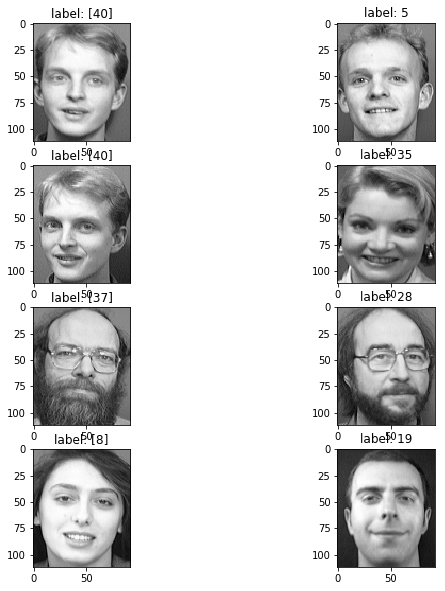

In [45]:
model_face_recognition(train_set,train_labels,test_set,test_labels,seed=seed,kind='euclid',show_err=True,index=3,pca_flag=1,
                      pca_energy=0.98,norm=1)

One of the most important applications of PCA is for speeding up machine learning algorithms.In this case 98% of the variance amount to 230 principal components.
Accuracy don't change and equal 95%

In [46]:
#Let's change pca_energy 0.95, 0.99, 1.00
model_face_recognition(train_set,train_labels,test_set,test_labels,seed=seed,kind='euclid',show_err=False,index=3,pca_flag=1,
                      pca_energy=0.95,norm=1)

PCA components = 161, explained variance = 0.95
New shape of train_set after applying PCA method = (320, 161)
New shape of test_set after applying PCA method = (80, 161)
Accuracy for test dataset = 95.0


95.0

In [47]:
model_face_recognition(train_set,train_labels,test_set,test_labels,seed=seed,kind='euclid',show_err=False,index=3,pca_flag=1,
                      pca_energy=0.99,norm=1)

PCA components = 265, explained variance = 0.99
New shape of train_set after applying PCA method = (320, 265)
New shape of test_set after applying PCA method = (80, 265)
Accuracy for test dataset = 95.0


95.0

In [48]:
model_face_recognition(train_set,train_labels,test_set,test_labels,seed=seed,kind='euclid',show_err=False,index=3,pca_flag=1,
                      pca_energy=0.999,norm=1)

PCA components = 311, explained variance = 0.999
New shape of train_set after applying PCA method = (320, 311)
New shape of test_set after applying PCA method = (80, 311)
Accuracy for test dataset = 95.0


95.0

Accuracy don't change and equal 95%. Accuracy reduces only when pca_energy <= 0.5

### LBP (Local Binary Pattern)

In [49]:
def lbp_describe(img,numPoints=8,radius=2):
    img_lbp=feature.local_binary_pattern(img,numPoints,radius)
    hist,_=np.histogram(img_lbp.ravel(),bins=np.arange(0, numPoints + 3), range=(0, numPoints + 2))
    return hist,img_lbp.ravel()

Text(0.5, 1.0, 'LBP_transformation')

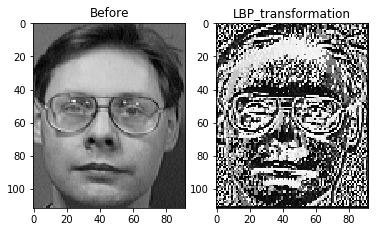

In [50]:
# Demonstarion of LBP transformation
path_="dataset/s4/1.pgm"
img=cv2.imread(path_, cv2.COLOR_BGR2GRAY)
plt.subplot(121)
plt.imshow(img,cmap='gray')
plt.title('Before')
plt.subplot(122)
img_lbp=feature.local_binary_pattern(img,9,1)
plt.imshow(img_lbp, cmap='gray')
plt.title('LBP_transformation')

In [51]:
def create_data_matrix_lbp(files,rows,columns,numPoints=8,radius=2,hist=False):
    row=0
    labels=[]
    if hist:
        columns = numPoints + 2
    data=np.zeros((rows,columns))
    for f in files:
        if not(hist):
            img=np.array(Image.open(f))
            _,img=lbp_describe(img,numPoints=numPoints,radius=radius)
        if hist:
            img=np.array(Image.open(f))
            img,_=lbp_describe(img,numPoints=numPoints,radius=radius)
              
        #create dataset: "data"
        data[row,:]=img
        row+=1
        #create labels for images: "labels"
        fname,ext = os.path.splitext(f)
        _,name,index, = fname.split('\\')
        labels.append(int(name[1:]))
    labels=np.array(labels).reshape(len(labels),1)
    return data, labels

In [52]:
# Transform all images using LBT transformation
data_lbt, labels = create_data_matrix_lbp(files,rows,columns,numPoints=24,radius=12,hist=False)

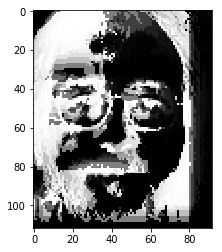

In [53]:
plt.imshow(data_lbt[200].reshape(112,92),cmap='gray')

In [54]:
# split data to train and test
train_lbt, train_labels, test_lbt, test_labels = split_dataset(data_lbt,seed=seed,n=80)
print(f'Train set shape: {train_lbt.shape}, train labels shape: {train_labels.shape}')
print(f'Test set shape: {test_lbt.shape}, test labels shape: {test_labels.shape}')

Train set shape: (320, 10304), train labels shape: (320, 1)
Test set shape: (80, 10304), test labels shape: (80, 1)


In [55]:
# Normalization using substruct mean method
model_face_recognition(train_lbt,train_labels,test_lbt,test_labels,seed=seed,kind='euclid',show_err=False,norm=1)

Accuracy for test dataset = 88.75


88.75

Accuracy for test dataset = 88.75
Predict photo                          Real photo


88.75

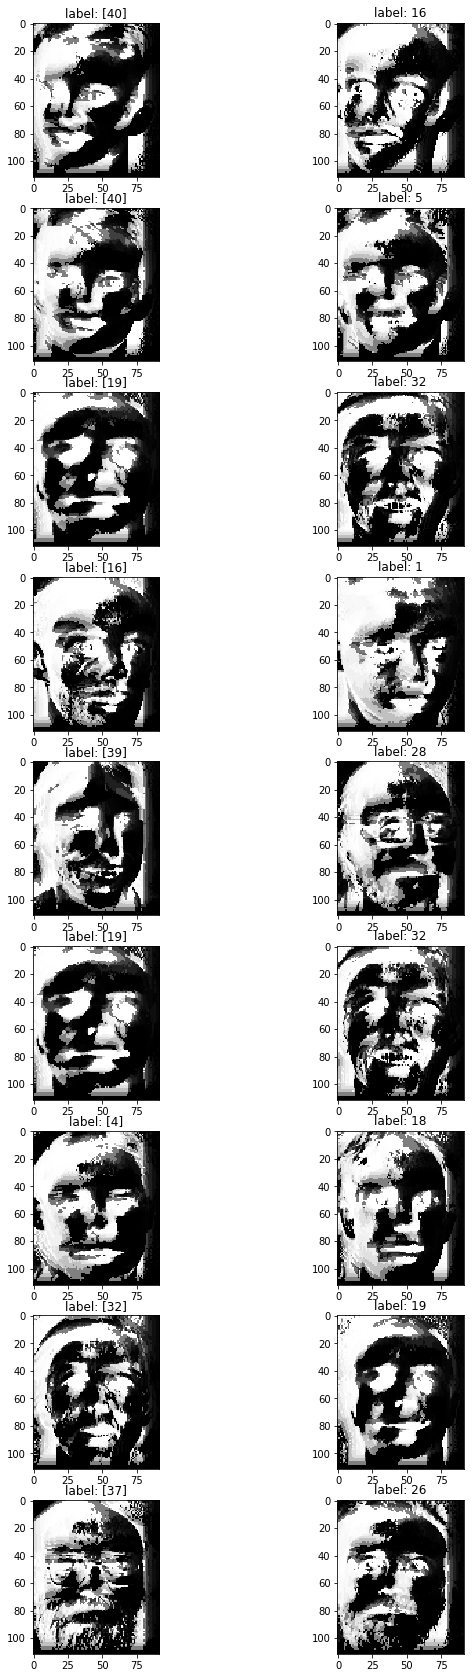

In [56]:
# Normalization using standard_norm method
model_face_recognition(train_lbt,train_labels,test_lbt,test_labels,seed=seed,kind='euclid',show_err=True,norm=2,figsize=(10,30))

We have good enough accuracy after implementation LBT algorithm. But accuracy is worse then before

In [57]:
#Let's build model using histogram which counts the number of times each of the LBP prototypes appears. 
data_lbt_hist, labels = create_data_matrix_lbp(files,rows,columns,numPoints=24,radius=12,hist=True)

In [58]:
data_lbt_hist.shape

(400, 26)

In [59]:
# split data to train and test
train_lbt_hist, train_labels, test_lbt_hist, test_labels = split_dataset(data_lbt_hist,seed=seed,n=80)
print(f'Train set shape: {train_lbt_hist.shape}, train labels shape: {train_labels.shape}')
print(f'Test set shape: {test_lbt_hist.shape}, test labels shape: {test_labels.shape}')

Train set shape: (320, 26), train labels shape: (320, 1)
Test set shape: (80, 26), test labels shape: (80, 1)


In [60]:
#Normalization - substract mean
model_face_recognition(train_lbt_hist,train_labels,test_lbt_hist,test_labels,seed=seed,kind='euclid',show_err=False,norm=1)

Accuracy for test dataset = 31.25


31.25

In [61]:
#Standardize
model_face_recognition(train_lbt_hist,train_labels,test_lbt_hist,test_labels,seed=seed,kind='euclid',show_err=False,norm=2)

Accuracy for test dataset = 32.5


32.5

Accuracy is very low. I don't recomen use this algoritm in this case.